# Anomaly detection with Keras, TensorFlow, and Deep Learning
https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import pickle
import cv2

## Autoencoder implementation

In [2]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        # Initialize the input shape to be "channels last" along with
        # the channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1
        
        # Define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        
        # Loop over the number of filters
        for f in filters:
            # Apply a CONV => Leaky ReLU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        # Flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        
        # Build the encoder model
        encoder = Model(inputs, latent, name="encoder")
        
        # Start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        
        # Loop over our number of filters again, but this time in reverse order
        for f in filters[::-1]:
            # Apply a CONV_TRANSPOSE => Leaky ReLU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        # Apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        
        # Build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")
        
        # Our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
        
        # Return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

## Function definition

In [3]:
def build_unsupervised_dataset(data, labels, validLabel=1, anomalyLabel=3, contam=0.01, seed=42):
    # Grab all indexes of the supplied class label that are *truly*
    # that particular label, then grab the indexes of the image
    # labels that will serve as our "anomalies"
    validIdxs = np.where(labels == validLabel)[0]
    anomalyIdxs = np.where(labels == anomalyLabel)[0]
    
    # Randomly shuffle both sets of indexes
    random.shuffle(validIdxs)
    random.shuffle(anomalyIdxs)
    
    # Compute the total number of anomaly data points to select
    i = int(len(validIdxs) * contam)
    anomalyIdxs = anomalyIdxs[:i]
    
    # Use NumPy array indexing to extract both the valid images and "anomaly" images
    validImages = data[validIdxs]
    anomalyImages = data[anomalyIdxs]
    
    # Stack the valid images and anomaly images together to form a
    # single data matrix and then shuffle the rows
    images = np.vstack([validImages, anomalyImages])
    np.random.seed(seed)
    np.random.shuffle(images)
    
    # Return the set of images
    return images


def visualize_predictions(decoded, gt, samples=10):
    # Initialize our list of output images
    outputs = None
    
    # Loop over our number of output samples
    for i in range(0, samples):
        # Grab the original image and reconstructed image
        original = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")
        
        # Stack the original and reconstructed image side-by-side
        output = np.hstack([original, recon])
        
        # If the outputs array is empty, initialize it as the current
        # side-by-side image display
        if outputs is None:
            outputs = output
            
        # Otherwise, vertically stack the outputs
        else:
            outputs = np.vstack([outputs, output])
            
    # Return the output images
    return outputs

## Settings

In [4]:
dataset_path = 'output/images.pickle' # Path to output dataset file
model_path = 'output/autoencoder.model' # Path to output trained autoencoder
quantile = 0.999  # q-th quantile used to identify outliers

# Initialize the number of epochs to train for, initial learning rate, and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

## Training

In [5]:
# Load the MNIST dataset
((trainX, trainY), (testX, testY)) = mnist.load_data()

# Build our unsupervised dataset of images with a small amount of
# contamination (i.e., anomalies) added into it
images = build_unsupervised_dataset(trainX, trainY, validLabel=1, anomalyLabel=3, contam=0.01)

# Add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

# Construct the training and testing split
(trainX, testX) = train_test_split(images, test_size=0.2, random_state=42)

# Construct our convolutional autoencoder
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

In [6]:
# Train the convolutional autoencoder
H = autoencoder.fit(trainX, trainX, validation_data=(testX, testX), epochs=EPOCHS, batch_size=BS)

Train on 5447 samples, validate on 1362 samples
Epoch 1/20
5447/5447 [==============================] - 3s 586us/sample - loss: 0.0418 - val_loss: 0.0421
Epoch 2/20
5447/5447 [==============================] - 3s 509us/sample - loss: 0.0090 - val_loss: 0.0292
Epoch 3/20
5447/5447 [==============================] - 3s 517us/sample - loss: 0.0041 - val_loss: 0.0094
Epoch 4/20
5447/5447 [==============================] - 3s 531us/sample - loss: 0.0033 - val_loss: 0.0030
Epoch 5/20
5447/5447 [==============================] - 3s 546us/sample - loss: 0.0028 - val_loss: 0.0027
Epoch 6/20
5447/5447 [==============================] - 3s 571us/sample - loss: 0.0027 - val_loss: 0.0024
Epoch 7/20
5447/5447 [==============================] - 3s 616us/sample - loss: 0.0025 - val_loss: 0.0025
Epoch 8/20
5447/5447 [==============================] - 3s 609us/sample - loss: 0.0024 - val_loss: 0.0024
Epoch 9/20
5447/5447 [==============================] - 4s 643us/sample - loss: 0.0022 - val_loss: 0.002

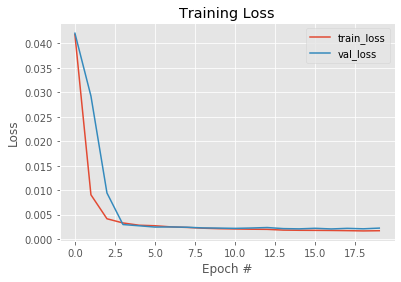

In [7]:
# Construct a plot that plots the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Serialize the image data to disk
f = open(dataset_path, "wb")
f.write(pickle.dumps(images))
f.close()

# Serialize the autoencoder model to disk
autoencoder.save(model_path, save_format="h5")

## Visualize performance

(-0.5, 55.5, 279.5, -0.5)

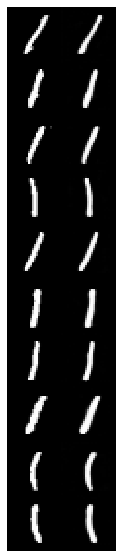

In [8]:
# Use the convolutional autoencoder to make predictions on the testing images,
# construct the visualization and display it
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
plt.figure(figsize=(10, 10))
plt.imshow(vis[..., 0], cmap='gray')
plt.axis('off')

## Find anomalies

In [9]:
# Load the model and image data from disk
autoencoder = load_model(model_path)
images = pickle.loads(open(dataset_path, "rb").read())

# Make predictions on our image data and initialize our list of reconstruction errors
decoded = autoencoder.predict(images)
errors = []

# Loop over all original images and their corresponding reconstructions
for (image, recon) in zip(images, decoded):
    # Compute the mean squared error between the ground-truth image
    # and the reconstructed image, then add it to our list of errors
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)
    
# Compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, quantile)
idxs = np.where(np.array(errors) >= thresh)[0]
print("MSE threshold: {}".format(thresh))
print("{} outliers found".format(len(idxs)))

MSE threshold: 0.025927889913320557
7 outliers found


(-0.5, 55.5, 195.5, -0.5)

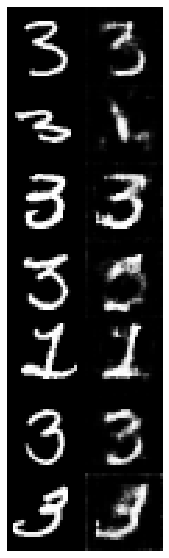

In [10]:
# Initialize the outputs array
outputs = None

# Loop over the indexes of images with a high mean squared error term
for i in idxs:
    # Grab the original image and reconstructed image
    original = (images[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")
    
    # Stack the original and reconstructed image side-by-side
    output = np.hstack([original, recon])
    
    # If the outputs array is empty, initialize it as the current
    # side-by-side image display
    if outputs is None:
        outputs = output
        
    # Otherwise, vertically stack the outputs
    else:
        outputs = np.vstack([outputs, output])
        
# Show the output visualization
plt.figure(figsize=(10, 10))
plt.imshow(outputs[..., 0], cmap='gray')
plt.axis('off')